In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
train_data = datasets.MNIST(root='./tmp/', train=True, transform=ToTensor(), download=True)
test_data = datasets.MNIST(root='./tmp/', train=False, transform=ToTensor())

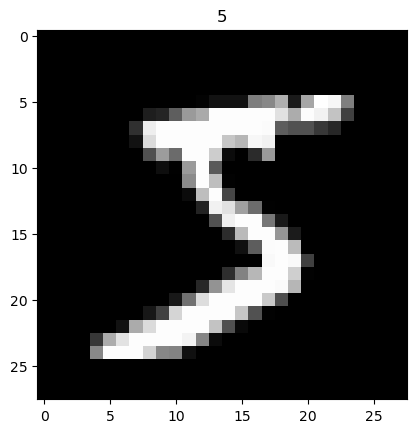

In [4]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

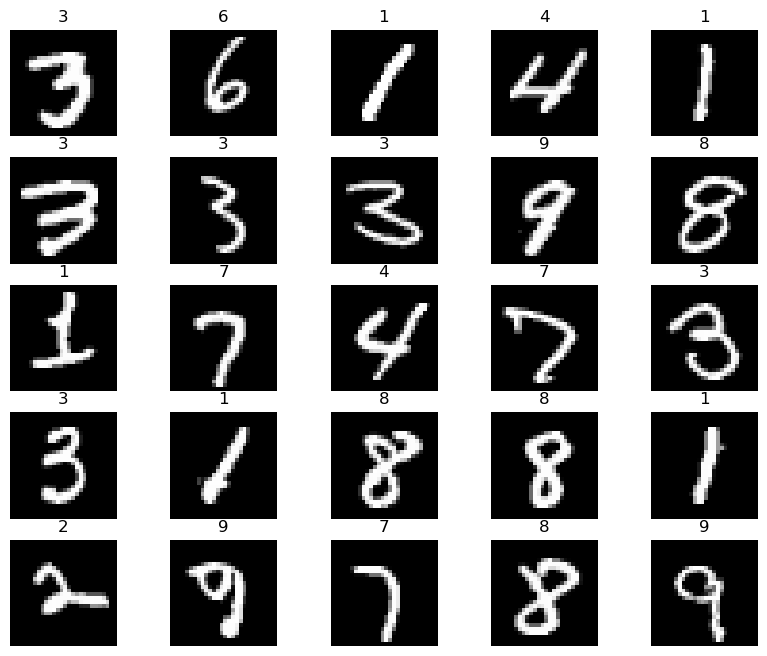

In [5]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    rand_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[rand_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [6]:
BATCH_SIZE = 64

In [7]:
loaders = {
    'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'test':  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb56c771d50>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb5716e6e10>}

In [8]:

class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flattening the output of conv2 layer to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        # returning output and x for visualization
        return output, x

model = MnistModel()
model

MnistModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01)
EPOCHS = 10

In [14]:
def train(model, data_loader, epochs=14):
    model.train()
    data_size = len(data_loader['train'])
    for epoch in range(EPOCHS):
        for batch_idx, (image, label) in enumerate(data_loader['train']):
            bx = Variable(image)
            by = Variable(label)
            output = model(bx)[0]
            loss = loss_function(output, by)
            # clear gradients for this training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss={:.4f}'.format(epoch + 1,
                    EPOCHS, batch_idx + 1, data_size, loss.item()))

In [13]:
train(model, loaders, epochs=1)

In [24]:
def test(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for image, label in data_loader['train']:
            test_output, last_layer = model(image)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == label).sum().item() / float(label.size(0))
    print('Accuracy: %.4f' % accuracy)

test(model, loaders)

Accuracy: 0.9688


In [26]:
sample = next(iter(loaders['train']))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

array([1, 9, 3, 0, 8, 3, 8, 9, 1, 6])

In [27]:
test_output, last_layer = model(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [1 9 3 0 8 3 8 9 1 6]
Actual number: [1 9 3 0 8 3 8 9 1 6]
